# Importing things which I may or may not need

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import Parameter
from qiskit.transpiler import CouplingMap
from rustworkx.visualization import graphviz_draw
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian
import numpy as np
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
)
from qiskit import QuantumCircuit
from qiskit.circuit.library import XXPlusYYGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.optimization.collect_and_collapse import (
    CollectAndCollapse,
    collect_using_filter_function,
    collapse_to_operation,
)
from functools import partial
from copy import deepcopy
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import real_amplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_ibm_runtime.debug_tools import Neat

from qiskit_ibm_runtime import QiskitRuntimeService
 


# Step 1

Initializing the hamiltonian using linear coupling map and

\begin{align}
J_{xx} &= 0.1, J_{yy} = 0.2, J_{zz} =0.3\,\\
h_x &= 0.4, h_y = 0.5, h_z = 0.6\,.
\end{align}

In [2]:
L = 20
 
coupling_map = CouplingMap.from_line(L, bidirectional=False)
 
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(0.1, 0.2, 0.3),
    ext_magnetic_field=(0.4, 0.5, 0.6),
)
 
print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIIIIIIIIXXI', 'IIIIIIIIIIIIIIIIIYYI', 'IIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIXXIII', 'IIIIIIIIIIIIIIIYYIII', 'IIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIXXIIIII', 'IIIIIIIIIIIIIYYIIIII', 'IIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIXXIIIIIII', 'IIIIIIIIIIIYYIIIIIII', 'IIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIXXIIIIIIIII', 'IIIIIIIIIYYIIIIIIIII', 'IIIIIIIIIZZIIIIIIIII', 'IIIIIIIXXIIIIIIIIIII', 'IIIIIIIYYIIIIIIIIIII', 'IIIIIIIZZIIIIIIIIIII', 'IIIIIXXIIIIIIIIIIIII', 'IIIIIYYIIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIII', 'IIIXXIIIIIIIIIIIIIII', 'IIIYYIIIIIIIIIIIIIII', 'IIIZZIIIIIIIIIIIIIII', 'IXXIIIIIIIIIIIIIIIII', 'IYYIIIIIIIIIIIIIIIII', 'IZZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIIYY', 'IIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIXXII', 'IIIIIIIIIIIIIIIIYYII', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIXXIIII', 'IIIIIIIIIIIIIIYYIIII', 'IIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIXXIIIIII', 'IIIIIIIIIIIIYYIIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIXXIIIIIIII', 'IIIIIIIIIIYYIIIIIIII', '

# Step 2

Defining things for building the trotterized circuit to evolve till $T = 0.2$ with 2 trotter step and 2nd order lie trotter decomposition.

In [3]:
mpf_trotter_steps = [2]
order = 2
symmetric = False
trotter_times = [0.0, 0.1, 0.2]

In [4]:
trotter_times

[0.0, 0.1, 0.2]

Just following tutorial and doing this, which is supposed to make transpilation more efficient.

In [5]:
def filter_function(node):
    return node.op.name in {"rxx", "ryy"}
 
 
collect_function = partial(
    collect_using_filter_function,
    filter_function=filter_function,
    split_blocks=True,
    min_block_size=1,
)
 
 
def collapse_to_xx_plus_yy(block):
    param = 0.0
    for node in block.data:
        param += node.operation.params[0]
    return XXPlusYYGate(param)
 
 
collapse_function = partial(
    collapse_to_operation,
    collapse_function=collapse_to_xx_plus_yy,
)
 
pm = PassManager()
pm.append(CollectAndCollapse(collect_function, collapse_function))

Preparing the circuit

In [6]:
initial_state_circ = QuantumCircuit(L)
 
all_circs = []
for total_time in trotter_times:
    mpf_trotter_circs = [
        generate_time_evolution_circuit(
            hamiltonian,
            time=total_time,
            synthesis=SuzukiTrotter(reps=num_steps, order=order),
        )
        for num_steps in mpf_trotter_steps
    ]
 
    mpf_trotter_circs = pm.run(
        mpf_trotter_circs
    )  # Collect XX and YY into XX + YY
 
    mpf_circuits = [
        initial_state_circ.compose(circuit) for circuit in mpf_trotter_circs
    ]
    all_circs.append(mpf_circuits)

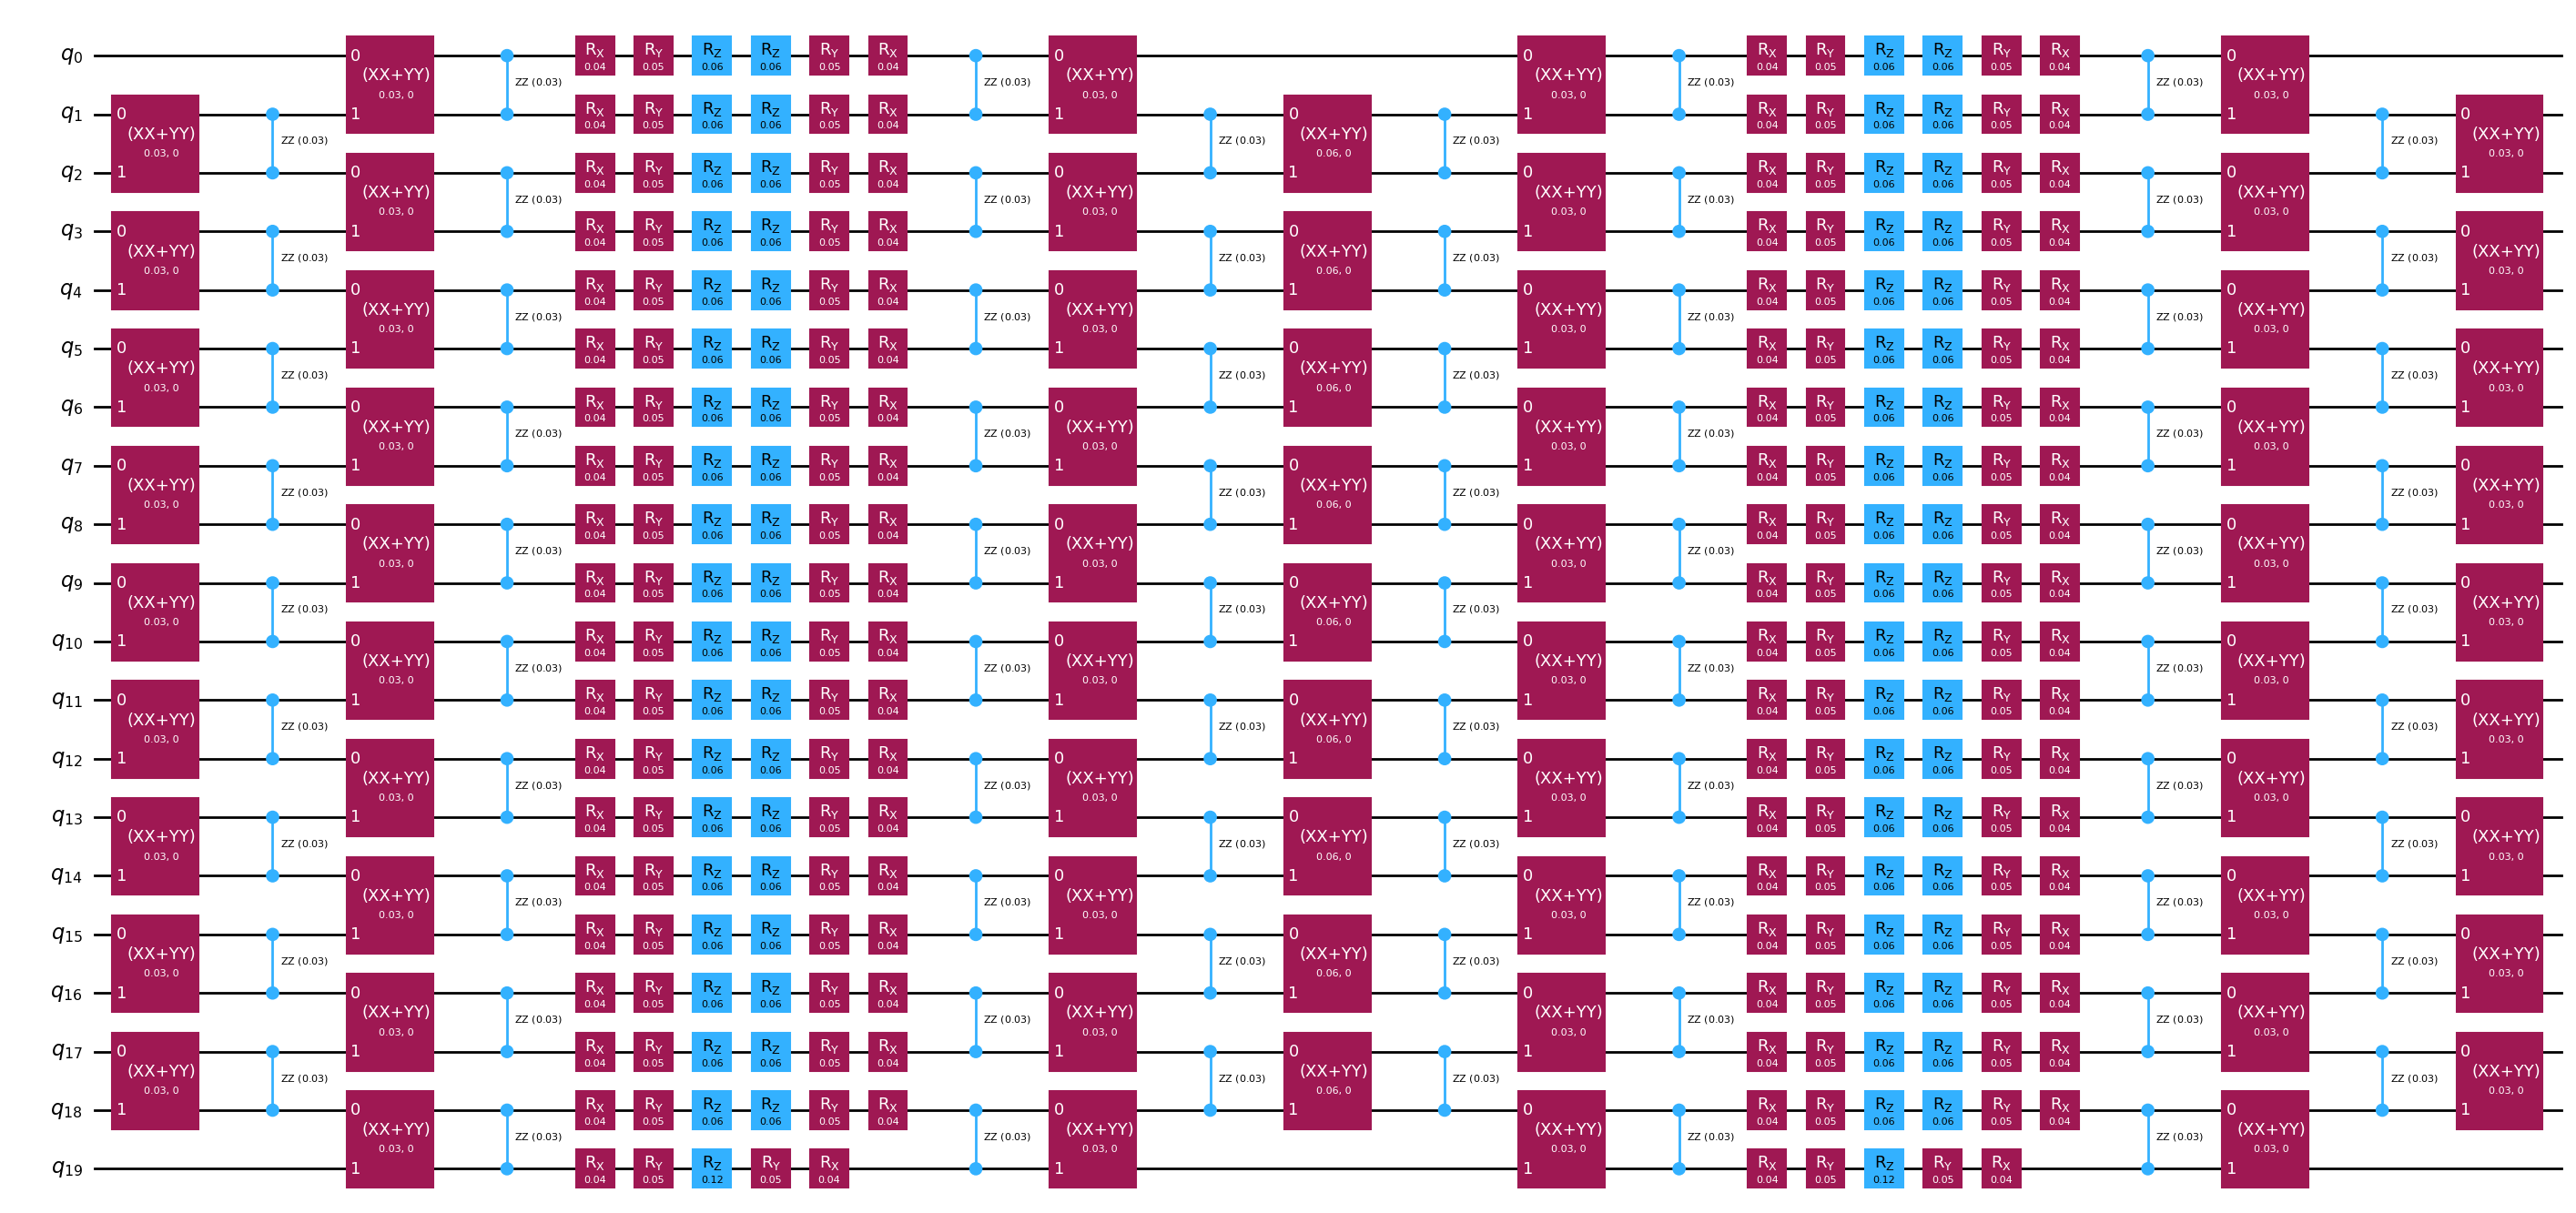

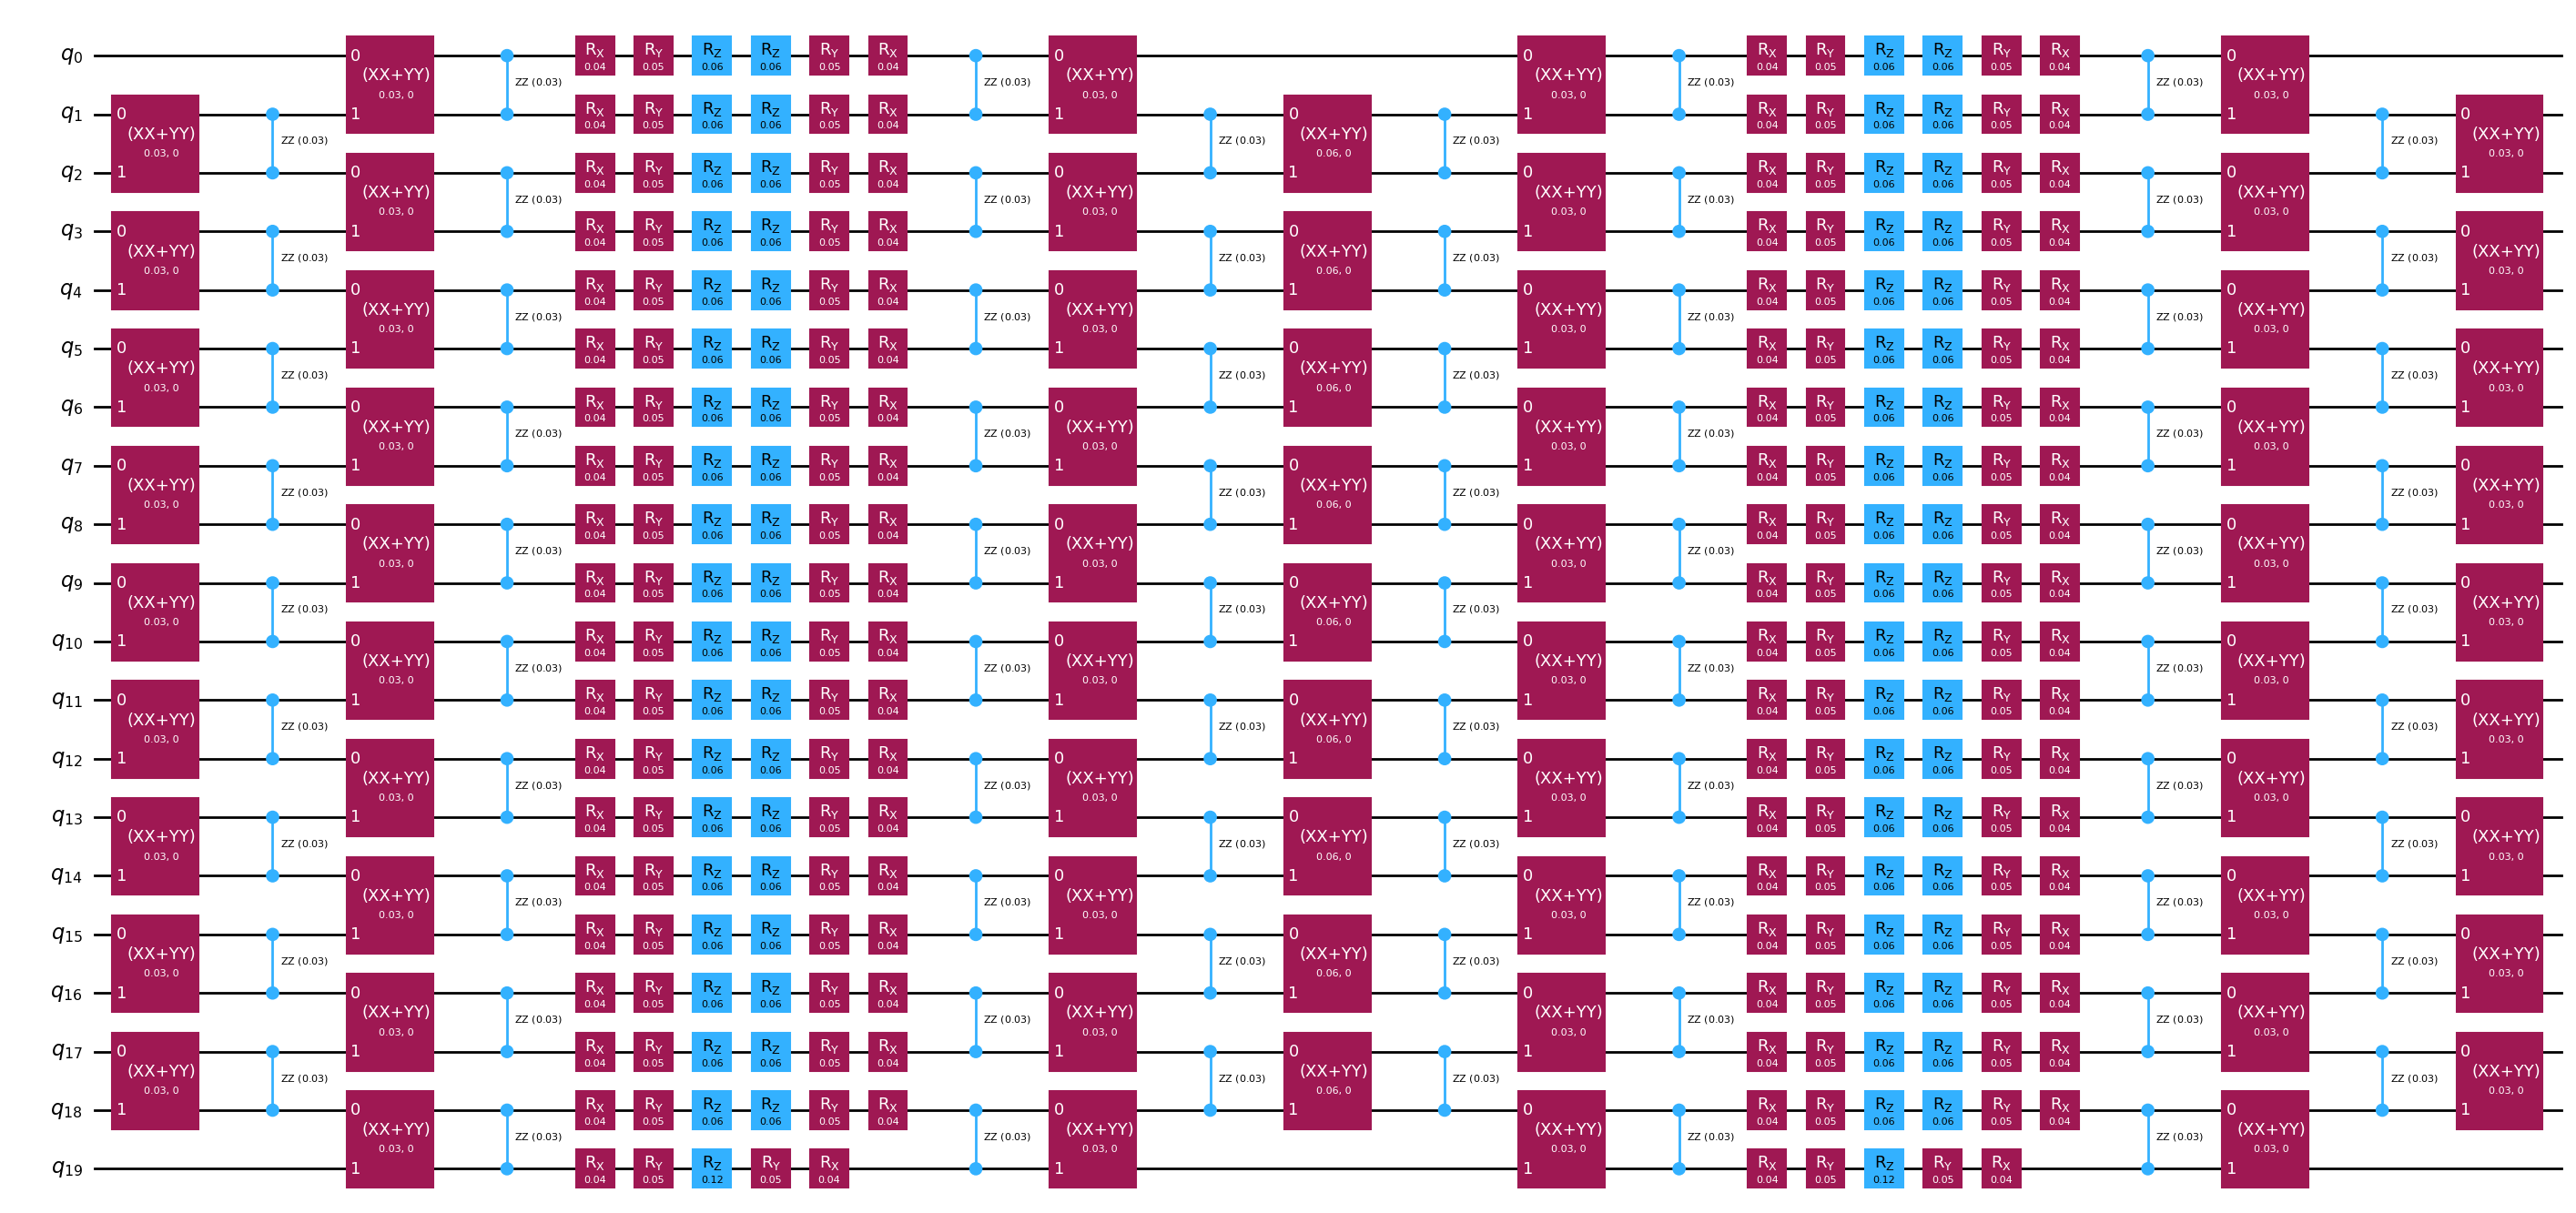

In [7]:
mpf_circuits[-1].draw("mpl", fold=-1)

# Step 3

Defining the observable
\begin{equation}
O = \frac{1}{20} \sum_{i=0}^{19} Z_i\,.
\end{equation}

In [8]:
paulis = []
coeffs = []

for i in range(L):
    s = ["I"] * L
    s[i] = "Z"
    paulis.append("".join(s))
    coeffs.append(1/20)

observable = SparsePauliOp(paulis, coeffs)
print(observable)

SparsePauliOp(['ZIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIZ'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j])


Finding the expentation values

In [9]:
aer_sim = AerSimulator()
estimator = Estimator(mode=aer_sim)
 
mpf_expvals_all_times, mpf_stds_all_times = [], []
for t, mpf_circuits in zip(trotter_times, all_circs):
    mpf_expvals = []
    circuits = [deepcopy(circuit) for circuit in mpf_circuits]
    pm_sim = generate_preset_pass_manager(
        backend=aer_sim, optimization_level=3
    )
    isa_circuits = pm_sim.run(circuits)
    result = estimator.run(
        [(circuit, observable) for circuit in isa_circuits], precision=0.005
    ).result()
    mpf_expvals = [res.data.evs for res in result]
    mpf_stds = [res.data.stds for res in result]
    mpf_expvals_all_times.append(mpf_expvals)
    mpf_stds_all_times.append(mpf_stds)

In [10]:
mpf_expvals_all_times[-1]

[array(0.967435)]

# Step 4

Defining the FakeTorino backend

In [11]:

backend = FakeTorino()

Transpiling the circuit for range(20)

Figure(2375.61x30300.7)


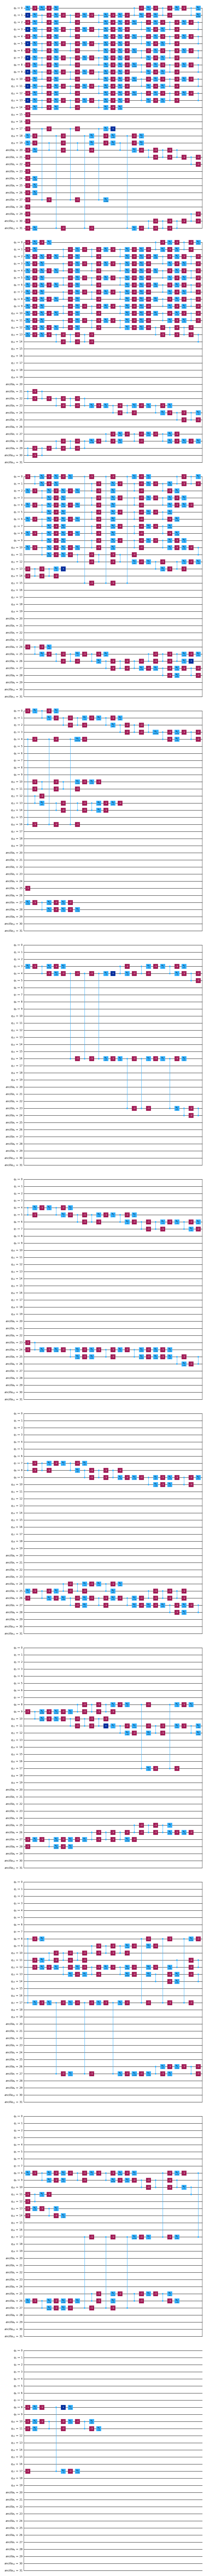

In [12]:
qc = mpf_circuits[-1]  
initial_layout = list(range(20))  
torino1 = transpile(
    qc,
    backend=backend,
    initial_layout=initial_layout,
    optimization_level=2
)
print(torino1.draw("mpl"))

Transpiling the circuit for range(10,30)

Figure(2375.61x27541.5)


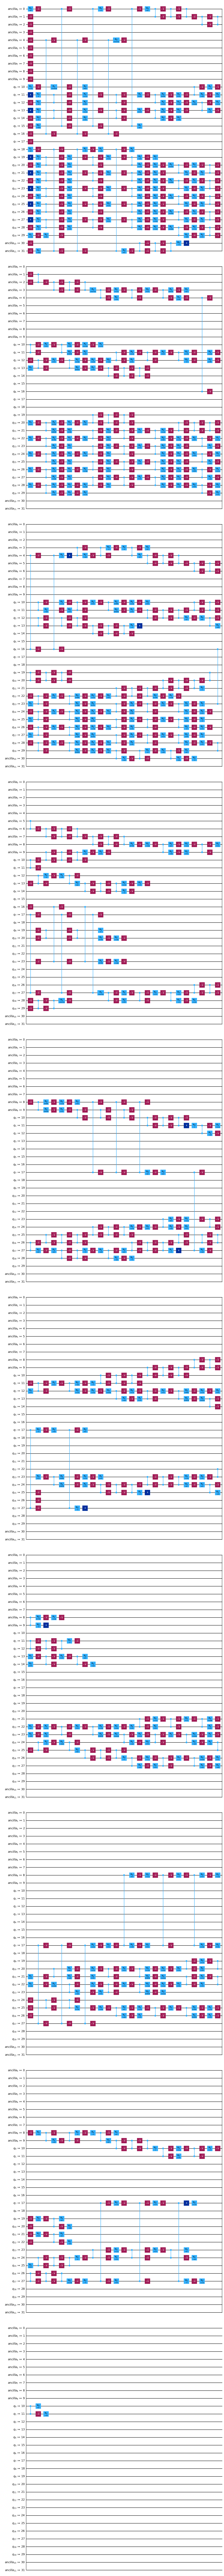

In [13]:
initial_layout = list(range(10,30))  
torino2 = transpile(
    qc,
    backend=backend,
    initial_layout=initial_layout,
    optimization_level=2
)
print(torino2.draw("mpl"))

Doing the last transpilation for range(20,40).

Figure(2376.21x31220.4)


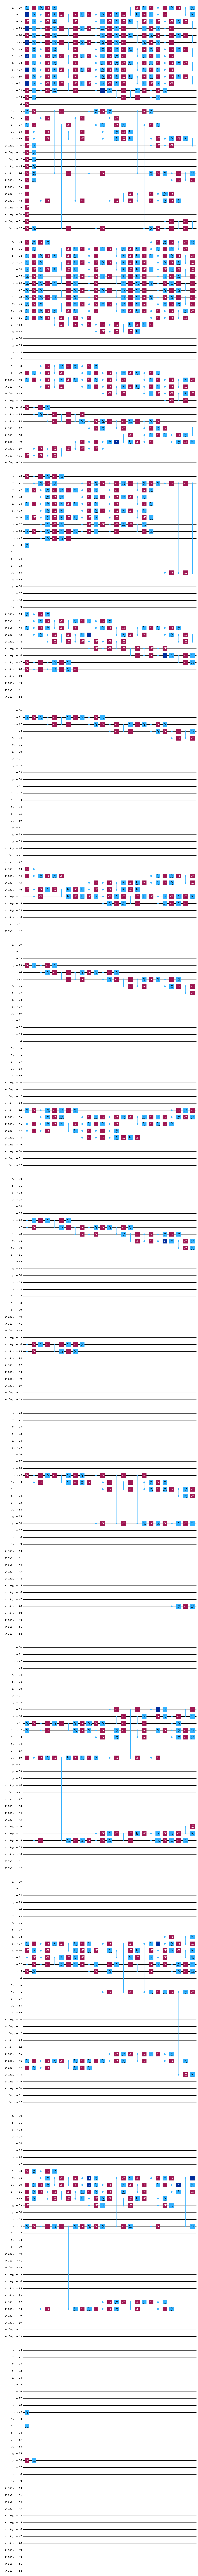

In [14]:
initial_layout = list(range(20,40))   
torino3 = transpile(
    qc,
    backend=backend,
    initial_layout=initial_layout,
    optimization_level=2
)
print(torino3.draw("mpl"))

# Step 5

Cliffordizing the three circuits we obtained in the previous step

In [15]:
analyzer = Neat(backend, None)
pubs = [(torino1, [observable]), (torino2, [observable]), (torino3, [observable])]
clifford_pubs = analyzer.to_clifford(pubs)


ValueError: The number of qubits of the circuit (133) does not match the number of qubits of the (0,)-th observable (20).

### Unforunately I got stuck here on Step 5 and cannot finish that and consequently, last step as well.